### CNN for Feature Extracting the Vibrational Data and Predicting Surface Roughness

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numpy.random import seed
import os
import random as rn

### Down Milling

#### Dataset

In [26]:
up_or_down = 'down'

In [27]:
cd = pd.DataFrame()
cu = pd.DataFrame()
rd = pd.DataFrame()
ru = pd.DataFrame()

In [28]:
for i in range(1, 101):
    if i == 49 or i == 50 or i == 52 or i == 73 or i == 92:
        continue
    clamp_down = pd.DataFrame(pd.read_csv("../../data/grouped_data/clamp_down_milling/E{}_clamp_down_milling.csv".format(i)).Acceleration_Y).transpose()
    clamp_up = pd.DataFrame(pd.read_csv("../../data/grouped_data/clamp_up_milling/E{}_clamp_up_milling.csv".format(i)).Acceleration_Y).transpose()
    clamp_down = clamp_down.rename(index={'Acceleration_Y': "E{}".format(i)})
    clamp_up = clamp_up.rename(index={'Acceleration_Y': "E{}".format(i)})
    cd = cd.append(clamp_down)
    cu = cd.append(clamp_up)
    robot_down = pd.DataFrame(pd.read_csv("../../data/grouped_data//robot_down_milling/E{}_robot_down_milling.csv".format(i)).Acceleration_Y).transpose()
    robot_up = pd.DataFrame(pd.read_csv("../../data/grouped_data//robot_up_milling/E{}_robot_up_milling.csv".format(i)).Acceleration_Y).transpose()
    robot_down = robot_down.rename(index={'Acceleration_Y': "E{}".format(i)})
    robot_up = robot_up.rename(index={'Acceleration_Y': "E{}".format(i)})
    rd = rd.append(robot_down)
    ru = ru.append(robot_up)

In [29]:
x1 = cd.copy()
x2 = rd.copy()

In [30]:
x1 = x1.to_numpy()
x2 = x2.to_numpy()

In [31]:
x = np.array([x1, x2])

In [32]:
x.shape

(2, 95, 200)

In [33]:
x = x.reshape(95, 200, 2)

In [34]:
y = pd.read_excel("../../data/input_new.xlsx").Ra_down
y = y.drop(index = [48, 49, 51, 72, 91], axis=0).reset_index(drop=True)
y = y.to_numpy()

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

In [36]:
x_train.shape

(76, 200, 2)

In [37]:
x_test.shape

(19, 200, 2)

In [38]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

#### CNN Model for both Robot and Clamp

In [39]:
def get_cnn_model(filtersLayerOne=64, kernelsizeLayerOne=3, filtersLayerTwo=32, kernelsizeLayerTwo=3,
                  pool_sizeOne=4, pool_sizeTwo=4,
                  DenseLayerOne=16, learnRate=0.01):

    model = Sequential()
    model.add(Conv1D(filtersLayerOne, kernelsizeLayerOne, activation="relu", input_shape=(200, 2)))
    model.add(keras.layers.MaxPooling1D(pool_size=pool_sizeOne))
    model.add(Conv1D(filtersLayerTwo, kernelsizeLayerTwo, activation="relu",))
    model.add(keras.layers.MaxPooling1D(pool_size=pool_sizeTwo))
    model.add(Flatten())
    model.add(Dense(DenseLayerOne, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=Adam(learning_rate=learnRate))    
    
    return model

In [16]:
# define a grid of the hyperparameter search space
filtersLayerOne = [16, 32, 64, 128, 256, 512,]
filtersLayerTwo = [8, 16, 32, 64, 128, 256, 512,]
kernelsizeLayerOne = [3, 5, 7, 9, 11, 13, 15]
kernelsizeLayerTwo = [3, 5, 7, 9, 11, 13, 15]
pool_sizeOne = [2, 3, 4, 5]
pool_sizeTwo = [2, 3, 4, 5]
DenseLayerOne = [8, 16, 32, 64, 128, 256, 512,]
learnRate = [1e-2, 1e-3, 1e-4]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    filtersLayerOne=filtersLayerOne,
    filtersLayerTwo=filtersLayerTwo,
    kernelsizeLayerOne=kernelsizeLayerOne,
    kernelsizeLayerTwo=kernelsizeLayerTwo,
    pool_sizeOne=pool_sizeOne,
    pool_sizeTwo=pool_sizeTwo,
    DenseLayerOne=DenseLayerOne,
    learnRate=learnRate,
    batch_size=batchSize,
    epochs=epochs
)

In [17]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_cnn_model, verbose=0)

/tmp/ipykernel_24222/3473721499.py:6: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=get_cnn_model, verbose=0)


In [18]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, n_iter=100, scoring="neg_mean_absolute_error", random_state=20)
searchResults = searcher.fit(x_train, y_train)

2022-01-16 09:34:44.993059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 09:34:44.993167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 09:34:44.993187: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-16 09:34:44.993239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 09:34:44.993255: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your mac

In [19]:
searchResults.best_params_

{'pool_sizeTwo': 3,
 'pool_sizeOne': 5,
 'learnRate': 0.0001,
 'kernelsizeLayerTwo': 11,
 'kernelsizeLayerOne': 11,
 'filtersLayerTwo': 8,
 'filtersLayerOne': 256,
 'epochs': 500,
 'batch_size': 4,
 'DenseLayerOne': 16}

In [40]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_cnn_model(filtersLayerOne=256, kernelsizeLayerOne=11, filtersLayerTwo=8, kernelsizeLayerTwo=11, pool_sizeOne=5, pool_sizeTwo=3, 
                     DenseLayerOne=16, learnRate=0.0001)

In [41]:
model.fit(x_train, y_train,
              batch_size=4,
              epochs=500, verbose=0)

In [42]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

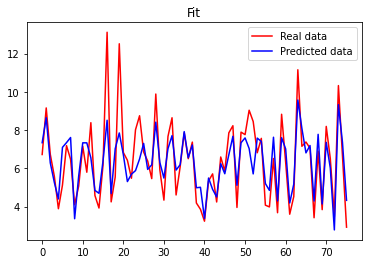

In [43]:
plt.plot(y_train, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [44]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 1.48
Coefficient of determination: 0.67
MAE:0.88
mean absolute percentage error:0.14


**Test Performance**

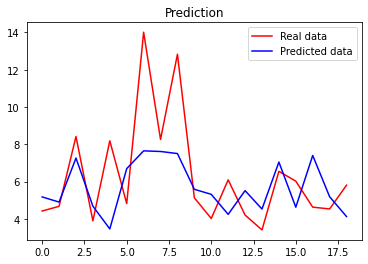

In [45]:
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

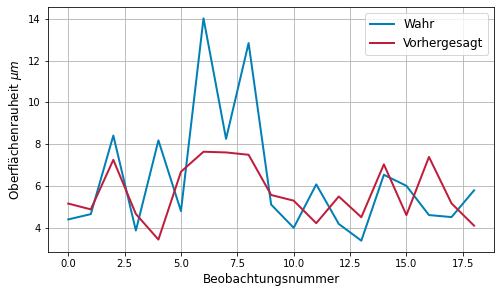

In [50]:
fig, ax = plt.subplots(figsize=(16/2, 9/2))
plt.plot(y_test, label='Wahr', color=(0/255, 128/255, 180/255), lw=2)
plt.plot(y_pred, label='Vorhergesagt', color=(190/255, 30/255, 60/255), lw=2)
plt.grid()
plt.xlabel('Beobachtungsnummer', fontsize=12)
plt.ylabel(r'Oberflächenrauheit $\mu m$', fontsize=12)
plt.legend(fontsize=12)

plt.savefig('../../images/CNN1.svg')

In [47]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 6.27
Coefficient of determination: 0.23
MAE:1.84
mean absolute percentage error:0.27


In [27]:
model.save('cnn_down')

2022-01-16 10:03:40.937125: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: cnn_down/assets


**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

### Up Milling

#### Dataset

In [28]:
up_or_down = 'up'

In [29]:
cd = pd.DataFrame()
cu = pd.DataFrame()
rd = pd.DataFrame()
ru = pd.DataFrame()

In [30]:
for i in range(1, 101):
    if i == 49 or i == 50 or i == 52 or i == 73 or i == 92:
        continue
    clamp_down = pd.DataFrame(pd.read_csv("../../data/grouped_data/clamp_down_milling/E{}_clamp_down_milling.csv".format(i)).Acceleration_Y).transpose()
    clamp_up = pd.DataFrame(pd.read_csv("../../data/grouped_data/clamp_up_milling/E{}_clamp_up_milling.csv".format(i)).Acceleration_Y).transpose()
    clamp_down = clamp_down.rename(index={'Acceleration_Y': "E{}".format(i)})
    clamp_up = clamp_up.rename(index={'Acceleration_Y': "E{}".format(i)})
    cd = cd.append(clamp_down)
    cu = cd.append(clamp_up)
    robot_down = pd.DataFrame(pd.read_csv("../../data/grouped_data//robot_down_milling/E{}_robot_down_milling.csv".format(i)).Acceleration_Y).transpose()
    robot_up = pd.DataFrame(pd.read_csv("../../data/grouped_data//robot_up_milling/E{}_robot_up_milling.csv".format(i)).Acceleration_Y).transpose()
    robot_down = robot_down.rename(index={'Acceleration_Y': "E{}".format(i)})
    robot_up = robot_up.rename(index={'Acceleration_Y': "E{}".format(i)})
    rd = rd.append(robot_down)
    ru = ru.append(robot_up)

In [31]:
x1 = cd.copy()
x2 = rd.copy()

In [32]:
x1 = x1.to_numpy()
x2 = x2.to_numpy()

In [33]:
x = np.array([x1, x2])

In [34]:
x.shape

(2, 95, 200)

In [35]:
x = x.reshape(95, 200, 2)

In [36]:
y = pd.read_excel("../../data/input_new.xlsx", sheet_name=1).Ra_up
y = y.drop(index = [48, 49, 51, 72, 91], axis=0).reset_index(drop=True)
y = y.to_numpy()

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

In [38]:
x_train.shape

(76, 200, 2)

In [39]:
x_test.shape

(19, 200, 2)

In [40]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

#### CNN Model for both Robot and Clamp

In [41]:
# define a grid of the hyperparameter search space
filtersLayerOne = [16, 32, 64, 128, 256, 512,]
filtersLayerTwo = [8, 16, 32, 64, 128, 256, 512,]
kernelsizeLayerOne = [3, 5, 7, 9, 11, 13, 15]
kernelsizeLayerTwo = [3, 5, 7, 9, 11, 13, 15]
pool_sizeOne = [2, 3, 4, 5]
pool_sizeTwo = [2, 3, 4, 5]
DenseLayerOne = [8, 16, 32, 64, 128, 256, 512,]
learnRate = [1e-2, 1e-3, 1e-4]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    filtersLayerOne=filtersLayerOne,
    filtersLayerTwo=filtersLayerTwo,
    kernelsizeLayerOne=kernelsizeLayerOne,
    kernelsizeLayerTwo=kernelsizeLayerTwo,
    pool_sizeOne=pool_sizeOne,
    pool_sizeTwo=pool_sizeTwo,
    DenseLayerOne=DenseLayerOne,
    learnRate=learnRate,
    batch_size=batchSize,
    epochs=epochs
)

In [42]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_cnn_model, verbose=0)

/tmp/ipykernel_24222/3473721499.py:6: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=get_cnn_model, verbose=0)


In [43]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, n_iter=100, scoring="neg_mean_absolute_error", random_state=20)
searchResults = searcher.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2022-01-16 10:04:34.407803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 10:04:34.413646: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-16 10:04:51.111151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-16 10:04:51.155833: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-16 10:04:51.

In [44]:
searchResults.best_params_

{'pool_sizeTwo': 2,
 'pool_sizeOne': 4,
 'learnRate': 0.01,
 'kernelsizeLayerTwo': 3,
 'kernelsizeLayerOne': 3,
 'filtersLayerTwo': 512,
 'filtersLayerOne': 64,
 'epochs': 100,
 'batch_size': 32,
 'DenseLayerOne': 32}

In [45]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_cnn_model(filtersLayerOne=64, kernelsizeLayerOne=3, filtersLayerTwo=512, kernelsizeLayerTwo=3, pool_sizeOne=4, pool_sizeTwo=2, 
                      DenseLayerOne=32, learnRate=0.01)

In [46]:
model.fit(x_train, y_train,
              batch_size=32,
              epochs=100, verbose=0)

In [47]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

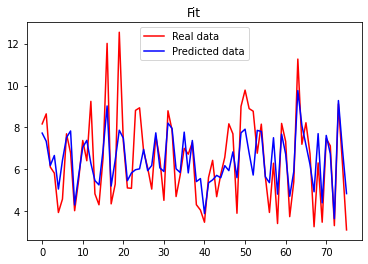

In [48]:
plt.plot(y_train, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [49]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 1.74
Coefficient of determination: 0.59
MAE:1.00
mean absolute percentage error:0.16


**Test Performance**

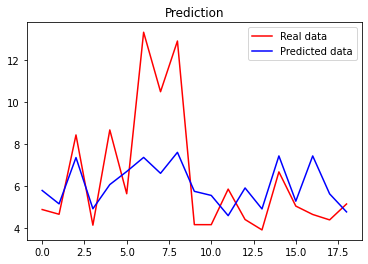

In [50]:
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [51]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 5.72
Coefficient of determination: 0.31
MAE:1.80
mean absolute percentage error:0.26


In [52]:
model.save('cnn_up')

INFO:tensorflow:Assets written to: cnn_up/assets


**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### 1D CNN for both Clamp- and Robot-vibrational Data - Test on Magnitude

#### Dataset

In [36]:
up_or_down = 'down'

In [37]:
cd = pd.DataFrame()
cu = pd.DataFrame()
rd = pd.DataFrame()
ru = pd.DataFrame()

In [38]:
for i in range(1, 101):
    if i == 49 or i == 50 or i == 52 or i == 73 or i == 92:
        continue
    clamp_down = pd.DataFrame(pd.read_csv("../../data/test_grouped_data/second_test/grouped_data/clamp_down_milling/E{}_clamp_down_milling.csv".format(i)).magnitude).transpose()
    clamp_up = pd.DataFrame(pd.read_csv("../../data/test_grouped_data/second_test/grouped_data/clamp_up_milling/E{}_clamp_up_milling.csv".format(i)).magnitude).transpose()
    clamp_down = clamp_down.rename(index={'magnitude': "E{}".format(i)})
    clamp_up = clamp_up.rename(index={'magnitude': "E{}".format(i)})
    cd = cd.append(clamp_down)
    cu = cd.append(clamp_up)
    robot_down = pd.DataFrame(pd.read_csv("../../data/test_grouped_data/second_test/grouped_data/robot_down_milling/E{}_robot_down_milling.csv".format(i)).magnitude).transpose()
    robot_up = pd.DataFrame(pd.read_csv("../../data/test_grouped_data/second_test/grouped_data/robot_up_milling/E{}_robot_up_milling.csv".format(i)).magnitude).transpose()
    robot_down = robot_down.rename(index={'magnitude': "E{}".format(i)})
    robot_up = robot_up.rename(index={'magnitude': "E{}".format(i)})
    rd = rd.append(robot_down)
    ru = ru.append(robot_up)

In [39]:
x1 = cd.copy()
x2 = rd.copy()

In [40]:
x1 = x1.to_numpy()
x2 = x2.to_numpy()

In [41]:
x = np.array([x1, x2])

In [42]:
x.shape

(2, 95, 200)

In [43]:
x = x.reshape(95, 200, 2)

In [44]:
y = pd.read_excel("../../data/input_new.xlsx").Ra_down
y = y.drop(index = [48, 49, 51, 72, 91], axis=0).reset_index(drop=True)
y = y.to_numpy()

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

In [46]:
x_train.shape

(76, 200, 2)

In [47]:
x_test.shape

(19, 200, 2)

In [48]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [49]:
def get_cnn_model(filtersLayerOne=64, kernelsizeLayerOne=3, filtersLayerTwo=32, kernelsizeLayerTwo=3,
                  filtersLayerThree=16, kernelsizeLayerThree=3, pool_sizeOne=4, pool_sizeTwo=4,
                  pool_sizeThree=2, DenseLayerOne=16, learnRate=0.01):

    model = Sequential()
    model.add(Conv1D(filtersLayerOne, kernelsizeLayerOne, activation="relu", input_shape=(200, 2)))
    model.add(keras.layers.MaxPooling1D(pool_size=pool_sizeOne))
    model.add(Conv1D(filtersLayerTwo, kernelsizeLayerTwo, activation="relu",))
    model.add(keras.layers.MaxPooling1D(pool_size=pool_sizeTwo))
    model.add(Conv1D(filtersLayerThree, kernelsizeLayerThree, activation="relu",))
    model.add(keras.layers.MaxPooling1D(pool_size=pool_sizeThree))
    model.add(Flatten())
    model.add(Dense(DenseLayerOne, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=Adam(learning_rate=learnRate))    
    
    return model

In [50]:
# define a grid of the hyperparameter search space
filtersLayerOne = [16, 32, 64, 128, 256]
filtersLayerTwo = [8, 16, 32, 64, 128]
filtersLayerThree = [4, 8, 16, 32, 64]
kernelsizeLayerOne = [3, 5, 7, 9, 11, 13, 15]
kernelsizeLayerTwo = [3, 5, 7, 9, 11, 13, 15]
kernelsizeLayerThree = [3, 5, 7, 9, 11, 13, 15]
pool_sizeOne = [2, 3, 4, 5]
pool_sizeTwo = [2, 3, 4, 5]
pool_sizeThree = [2, 3, 4, 5]
DenseLayerOne = [8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    filtersLayerOne=filtersLayerOne,
    filtersLayerTwo=filtersLayerTwo,
    filtersLayerThree=filtersLayerThree,
    kernelsizeLayerOne=kernelsizeLayerOne,
    kernelsizeLayerTwo=kernelsizeLayerTwo,
    kernelsizeLayerThree=kernelsizeLayerThree,
    pool_sizeOne=pool_sizeOne,
    pool_sizeTwo=pool_sizeTwo,
    pool_sizeThree=pool_sizeThree,
    DenseLayerOne=DenseLayerOne,
    learnRate=learnRate,
    batch_size=batchSize,
    epochs=epochs
)

In [51]:
model = KerasRegressor(build_fn=get_cnn_model, verbose=0)

/tmp/ipykernel_13501/4169575899.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=get_cnn_model, verbose=0)


In [52]:
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

2022-01-04 12:08:20.131562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-04 12:08:20.131799: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-04 12:08:20.201535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-04 12:08:20.201724: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-04 12:08:20.202055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

In [82]:
searchResults.best_params_

{'pool_sizeTwo': 3,
 'pool_sizeThree': 5,
 'pool_sizeOne': 3,
 'learnRate': 0.001,
 'kernelsizeLayerTwo': 15,
 'kernelsizeLayerThree': 13,
 'kernelsizeLayerOne': 3,
 'filtersLayerTwo': 32,
 'filtersLayerThree': 32,
 'filtersLayerOne': 128,
 'epochs': 200,
 'batch_size': 32,
 'DenseLayerOne': 64}

In [84]:
model = get_cnn_model(filtersLayerOne=128, kernelsizeLayerOne=3, filtersLayerTwo=32, kernelsizeLayerTwo=15, filtersLayerThree=32, 
                     kernelsizeLayerThree=13, pool_sizeOne=3, pool_sizeTwo=3, pool_sizeThree=5, DenseLayerOne=64, learnRate=0.001)

In [85]:
model.fit(x_train, y_train,
              batch_size=32,
              epochs=100, verbose=0)

In [86]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

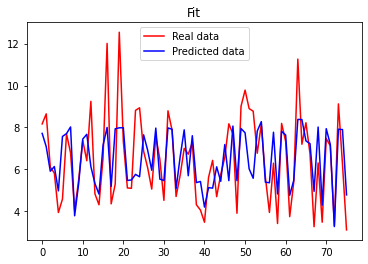

In [87]:
plt.plot(y_train, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [88]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 2.29
Coefficient of determination: 0.46
MAE:1.14
mean absolute percentage error:0.18


**Test Performance**

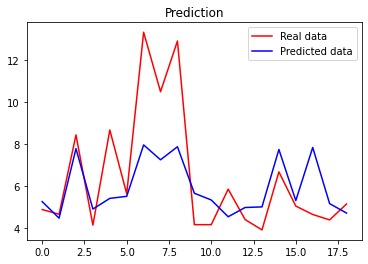

In [89]:
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [90]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 5.02
Coefficient of determination: 0.40
MAE:1.60
mean absolute percentage error:0.23


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 155, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "/tmp/ipykernel_13501/918783777.py", line 11, in get_cnn_model
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/training/tracking/base.py", line 530, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/pyth